In [1]:
#NLTK, emoji and general libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import re                                  
import string                             
from nltk.corpus import stopwords 
from nltk.tokenize import TweetTokenizer
tok=TweetTokenizer()
from nltk.stem import WordNetLemmatizer
import emoji
import os
nltk.download('punkt')
lem=WordNetLemmatizer()
nltk.download('wordnet')
import seaborn as sns
#Naive bayes Model libraries:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn import metrics 


#For metrics and scores:
from sklearn.metrics import confusion_matrix,accuracy_score

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction import CountVectorizer

#SMOTE pip install imblearn this is not a common library!
from imblearn.over_sampling import RandomOverSampler,SMOTE

#SVM classifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

#for polarity Label encoding
from sklearn.preprocessing import LabelEncoder 



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/panagiotissotirellos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/panagiotissotirellos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/panagiotissotirellos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


# Read and Concatenate Data

In [267]:
#Initialisation settings to see the whole data:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max.colwidth',400)
#read all data sets with the same headers change path to use ur datasets
df_train = pd.read_csv('twitter-training-data.txt',sep='\t',names=["id","polarity","tweet"])
df_dev= pd.read_csv('twitter-dev-data.txt',sep='\t',names=["id","polarity","tweet"]) 
df_test_1=pd.read_csv('twitter-test1.txt',sep='\t',names=["id","polarity","tweet"])
df_test_2=pd.read_csv('twitter-test2.txt',sep='\t',names=["id","polarity","tweet"])
df_test_3=pd.read_csv('twitter-test3.txt',sep='\t',names=["id","polarity","tweet"])

#We will now append training and development data this gives 47026 rows
#this is a good practice and will increase our performance since the model will train on more data
#we use ignore_index=true to avoid double rows

df_final=df_train.append(df_dev,ignore_index=True)



In [268]:
df_final#2000(dev)+45026(training) rows

,id,polarity,tweet
0,335104872099066692,positive,Felt privileged to play Foo Fighters songs on guitar today with one of the plectrums from the gig on Saturday.
1,796528524030124618,positive,"@AaqibAfzaal Pakistan may be an Islamic country, but der are a lot true Muslims in India who love their country and can sacrifice all for it"
2,760964834217238632,positive,Happy Birthday to the coolest golfer in Bali! @tjvictoriacnd !! :) may you become cooler and cooler everyday! Stay humble little sister! Xx
3,147713180324524046,negative,@SimpplyA TMILLS is going to Tucson! But the 29th and it's on a Thursday :(
4,732302280474120023,negative,Hmmmmm where are the #BlackLivesMatter when matters like this a rise... kids are a disgrace!! https://t.co/aPrB0VtvCN
...,...,...,...
47021,648550834532150634,positive,can it just be 5:30 tomorrow evening alREADY because Ant-Man will be over by then and the post credits will BEGIN https://t.co/wAIUNnsj9i
47022,22324697041215693,neutral,Look for me on @GMA tomorrow at 7:34am talking about @people's exclusive: Hulk Hogan Apologizes for 'Unacceptable' Racist Rant
47023,885111074317866321,neutral,@TheShannonBurke after @immandaschmidt's call I foresee the jackals lining up for studio visits on Thursday's.
47024,691260170402024265,neutral,"Taking Go Set a Watchman with me to the beach tomorrow, the critics haven't put me off in the slightest http://t.co/qFMjK7x8Cg"


# Expand Contracted Words

In [269]:
#define a function to expand contracted words. we need to do that to tokenize them more efficiently (we use the func in preprocessing)
#this is a good practice, dict taken from (https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

def expandContr(expression):
    # specific expansions
    expression = re.sub(r"won\'t", "will not", expression)
    expression = re.sub(r"can\'t", "can not", expression)

    # Most used generalized contractions and expansions
    expression = re.sub(r"n\'t", " not", expression)
    expression = re.sub(r"\'re", " are", expression)
    expression = re.sub(r"\'s", " is", expression)
    expression = re.sub(r"\'d", " would", expression)
    expression = re.sub(r"\'ll", " will", expression)
    expression = re.sub(r"\'t", " not", expression)
    expression = re.sub(r"\'ve", " have", expression)
    expression = re.sub(r"\'m", " am", expression)
    
    return expression

In [270]:
#check if func works
expandContr("won't")

'will not'

#  Remove smileys and replace them with their meaning

In [385]:
#similar logic as before, this will help us infer greater meaning since smileys usually convey emotions
#so we will initialise a dictionary of them and create a function that loops through our datasets and replaces them
#with their meaning

mapping={":‑)":"smiley",":-]":"smiley",":-3":"smiley",":->":"smiley","8-)":"smiley",":-}":"smiley",":)":"smiley",
":]":"smiley",":3":"smiley",":>":"smiley","8)":"smiley",":}":"smiley",":o)":"smiley",":c)":"smiley",":^)":"smiley",
"=]":"smiley","=)":"smiley",":-))":"smiley",":‑D":"smiley","8‑D":"smiley","x‑D":"smiley","X‑D":"smiley",":D":"smiley",
"8D":"smiley","xD":"smiley","XD":"smiley",":‑(":"sad",":‑c":"sad",":‑<":"sad",":‑[":"sad",":(":"sad",":c":"sad",":<":"sad",
":[":"sad", ":-||":"sad",">:[":"sad",":{":"sad",":@":"sad", ">:(":"sad",":'‑(":"sad",":'(":"sad",":‑P":"playful",
"X‑P":"playful","x‑p":"playful",":‑p":"playful",":‑Þ":"playful",":‑þ":"playful",":‑b":"playful",":P":"playful", "XP":"playful",
"xp":"playful",":p":"playful",":Þ":"playful", ":þ":"playful", ":b":"playful","<3":"love" }


    
def sub_smiley(text):
    word_list=[]
    for word in text.split():

        if mapping.get(word):
            word=mapping.get(word)
            word_list.append(word)
        
        else:
            word_list.append(word)

    return ' '.join(word_list)

    
    

In [272]:
#apply function to all datasets in the pre-processing code block (just include the above function to the preproc function)
df_final['tweet']=df_final['tweet'].apply(sub_smiley)



In [273]:
#Use english stopwords from library. we will use that in preprocessing to remove tokens (words) that are stopwords

stopwords=set(stopwords.words('english'))

# Tokenization,Lemmatization,Stop words and  Text-Preprocessing


In [274]:
#in order to be able to apply any classifier, we need to first pre-process the text. We will do that using  a for loop.
#We will focus on lowercasing the text, replacing hashtags, emojis and numbers as well as


#Pre-process the tweets



#create a function to clean text

def clean_text(text):
    text=re.sub(r'@[A-Za-z0-9]+','mentions',text) #replace @ mentions
    text=re.sub(r'#[A-Za-z0-9]+','hashtags',text) #replace hashtags
    text=re.sub(r'www.\.[\S]+|(https?://[\S]+)','url',text) #replace URLS
    text=text.lower() #make everything lowercase for the vectorization to work better 
    text=re.sub(r'[.,!?:;-=/+&\\''@#_]',' ',text)#remove punctuation and (/ + & - \\ symbols)
    text=re.sub(r'[0-9]',' ',text) #remove all numbers 
    # text=re.sub(r' {2,}','',text) #remove double whitespace(dont use that to include smiley)
    text=re.sub(r'([a-zA-Z])(\1){2,}', r'\1',text)#remove multiple letters from words
    text=emoji.demojize(text) # replace emojis with their meaning
    text=expandContr(text) #expand contracted words with the function created
    text=re.sub(r'\b[a-zA-Z]\b', ' ',text) #remove one character words
    text=sub_smiley(text) #use the smiley function to replace smileys with their meaning
    
    return text
    

#apply function and create new column in datasets with cleaned text

df_final['clean']=df_final['tweet'].apply(clean_text)
df_test_1['clean']=df_test_1['tweet'].apply(clean_text)
df_test_2['clean']=df_test_2['tweet'].apply(clean_text)
df_test_3['clean']=df_test_3['tweet'].apply(clean_text)

#tokenize text and create column with tokenized text, make sure to only add tokens not in stop words :
# the code below applies tokenization,lemmatization and stop word removal all in 1:

df_final['tokenized']=df_final['clean'].apply(lambda x : ' '.join([lem.lemmatize(token) for token in tok.tokenize(x) if token not in stopwords]))
df_test_1['tokenized']=df_test_1['clean'].apply(lambda x : ' '.join([lem.lemmatize(token) for token in tok.tokenize(x) if token not in stopwords]))
df_test_2['tokenized']=df_test_2['clean'].apply(lambda x : ' '.join([lem.lemmatize(token) for token in tok.tokenize(x) if token not in stopwords]))
df_test_3['tokenized']=df_test_3['clean'].apply(lambda x : ' '.join([lem.lemmatize(token) for token in tok.tokenize(x) if token not in stopwords]))














In [121]:
#now the datasets will have a 'tokenized' column with the pre processed text ready to be fed into a classifier
df_test_1.head(20)

,id,polarity,tweet,clean,tokenized
0,163361196206957578,neutral,Candids: Heading to the Chateau Marmont in West Hollywood (October 10th) http://t.co/87hjAFmB,candids heading to the chateau marmont in west hollywood (october th) url,candids heading chateau marmont west hollywood ( october th ) url
1,768006053969268950,negative,@Dont__KAY_me omg same I was reading it in school after PSSAS and I just sat there crying,mentions kay me omg same was reading it in school after pssas and just sat there crying,mention kay omg reading school pssas sat cry
2,742616104384772304,neutral,Watching MTV Hits! The Wanted Chasing the sun!,watching mtv hits the wanted chasing the sun,watching mtv hit wanted chasing sun
3,102313285628711403,neutral,"Bing one-ups knowledge graph, hires Encyclopaedia Britannica to supply results: It may have retired from the cut-throat world of pr...",bing one-ups knowledge graph hires encyclopaedia britannica to supply results it may have retired from the cut-throat world of pr,bing one-ups knowledge graph hire encyclopaedia britannica supply result may retired cut-throat world pr
4,653274888624828198,neutral,"On Thursday, concealed-carry gun license holders will be given a new right in the state of Oklahoma: the ability... http://t.co/oSgGHKi1",on thursday concealed-carry gun license holders will be given new right in the state of oklahoma the ability url,thursday concealed-carry gun license holder given new right state oklahoma ability url
5,420747042670198316,negative,Miyagi just got banned from yoga. He was caught him sniffing the sphincter of the girl in front of him. There may be police involvement!,miyagi just got banned from yoga he was caught him sniffing the sphincter of the girl in front of him there may be police involvement,miyagi got banned yoga caught sniffing sphincter girl front may police involvement
6,865097686752334952,positive,"Hey friends, DST ends Sunday, 11/4. Just giving you a heads-up to set your clocks back 1hr before bed Saturday evening. :)",hey friends dst ends sunday just giving you heads-up to set your clocks back hr before bed saturday evening ),hey friend dst end sunday giving heads-up set clock back hr bed saturday evening )
7,822064800445716046,neutral,Join us tonight at Boston Pizza - Centre on Barton for THURSDAY NIGHT FOOTBALL! Tonight the Chiefs take on the... http://t.co/iegTxPQv,join us tonight at boston pizza - centre on barton for thursday night football tonight the chiefs take on the url,join u tonight boston pizza - centre barton thursday night football tonight chief take url
8,55480020953212084,neutral,"#FX NEW YORK, Oct 18 (Reuters) - The Federal Reserve provided $4.701 billion of liquidity to the ... http://t.co/BJhIQTtO #EUR #AUD #CAD",hashtags new york oct (reuters) - the federal reserve provided $ billion of liquidity to the url hashtags hashtags hashtags,hashtags new york oct ( reuters ) - federal reserve provided $ billion liquidity url hashtags hashtags hashtags
9,170392754891582126,neutral,Them Seniors gone beat the Juniors tomorrow.,them seniors gone beat the juniors tomorrow,senior gone beat junior tomorrow


In [164]:
test_labels_1

array([1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 1, 2, 2, 0, 2,
       2, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 0, 2,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1, 2, 2, 2, 1, 0, 2, 2, 2, 1, 1, 1,
       2, 1, 0, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 2, 1, 1, 1,
       1, 0, 1, 0, 2, 2, 0, 1, 2, 0, 1, 1, 2, 1, 2, 2, 1, 0, 2, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 1, 1, 1, 0, 1, 2, 1, 1, 2,
       2, 2, 2, 2, 1, 2, 2, 0, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 0, 2,
       2, 2, 2, 0, 1, 2, 1, 0, 1, 2, 2, 2, 1, 2, 2, 2, 0, 1, 0, 2, 2, 1,
       0, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 0, 2, 1, 0,
       1, 1, 0, 0, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 0, 2, 1, 2, 2, 2, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2,
       2, 2, 1, 1, 2, 1, 0, 2, 2, 2, 0, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2,
       0, 1, 0, 1, 0, 0, 2, 1, 0, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       2, 0, 1, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 1, 1,

In [124]:
#check overall balance of trained dataset to see if we need to normalize/SMOTE because of imbalanced classes
#the result clearly shows we have an imbalanced dataset, we can address that with SMOTE
print(df_final['polarity'].value_counts())

neutral     21668
positive    16663
negative     8695
Name: polarity, dtype: int64


In [275]:
df_final['clean'][1]

'mentions pakistan may be an islamic country but der are lot true muslims in india who love their country and can sacrifice all for it'

In [276]:
df_final['tokenized'][1]

'mention pakistan may islamic country der lot true muslim india love country sacrifice'

# Label Encoding

In [294]:
#convert Polarity[negative,neutral,positive] to [0,1,2] for all datasets

#create a function to label encode your polarity

def convert_labels(dataset):
    
    get_polarity=dataset['polarity'].values
    get_tweets=dataset['tokenized'].values
    # intsatiate label encoder 
    label_encoder=LabelEncoder()
    #convert strings (negative,neutral,positive,) to integers (0,1,2)
    get_polarity_score=label_encoder.fit_transform(get_polarity)
    
    return get_tweets,get_polarity_score








In [278]:
#apply the encoding function to all datasets so we can feed to our models later (0->Negative|1->Neutral|2->positive)
#create arrays of polarity labels
train_text,train_polarity_labels=convert_labels(df_final)
test_tweets_1,test_labels_1=convert_labels(df_test_1)
test_tweets_2,test_labels_2=convert_labels(df_test_2)
test_tweets_3,test_labels_3=convert_labels(df_test_3)

In [130]:
# check that polarity labels were applied
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


train_polarity_labels

array([2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 2, 1, 1, 1,
       2, 1, 2, 2, 2, 1, 0, 1, 2, 0, 1, 2, 1, 0, 2, 2, 1, 1, 2, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 2, 1, 0, 1, 0, 2, 0, 1, 0, 1, 2, 1, 2, 2, 2, 2,
       0, 2, 2, 1, 2, 1, 2, 1, 0, 1, 0, 1, 2, 2, 0, 2, 1, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2,
       1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 0, 1, 1, 1, 2, 0, 2, 2, 1,
       2, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2,
       0, 0, 2, 0, 2, 1, 0, 0, 2, 1, 2, 2, 0, 1, 1, 2, 2, 1, 0, 2, 1, 0,
       1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 1, 1, 2, 1, 2, 0,
       1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 1, 0, 1, 2, 2, 1, 1,
       2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1,
       0, 1, 2, 0, 2, 2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 1, 2, 2, 0, 1, 1, 0,
       1, 2, 2, 1, 2, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2,

#  Visualize Class Imbalance 

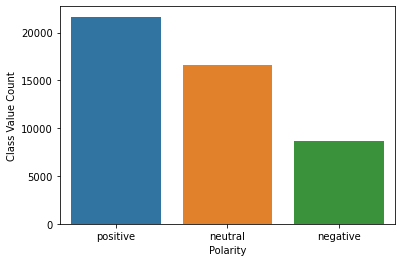

In [384]:
import matplotlib.pyplot as plt

#class imbalance in training set
dd = pd.Series(train_polarity_labels).value_counts()
bar=sns.barplot(x=np.array(['positive','neutral','negative']),y=dd.values)
bar.set(xlabel='Polarity',ylabel='Class Value Count')
plt.show()


In [379]:
import seaborn as sns
import matplotlib.pyplot as plt

In [376]:
ax = sns.barplot(x = 'val', y = 'cat', 
              data = fake, 
              color = 'black')
ax.set(xlabel='common xlabel', ylabel='common ylabel')
plt.show()

<Figure size 432x288 with 0 Axes>

# Smote to balance labels & TF-IDF  for vectorizing




In [280]:
#The dataset is clearly imbalanced (only 8695 labels are negative out of the 47k total
#We can fix that with Smote(synthetic oversamplig technique), but before we SMOTE we need to vectorize (TF-IDF)


#Use TF-IDF as a vectorising technique instead of BOW or others
#this is because TF-IDF will give scemantic meaning to the words with the weights appied and yield better final results


#need to play around with value to get optimal parameters.  unigrams to tri-grams usually yield the better accuracy thus we use range 1-3
vectorizer=TfidfVectorizer(ngram_range=(1,3),min_df=2) #ignore terms appearing less than 2 documents
# apply in all datasets (the combined dev+train) and the test tweets
training_for_smote=vectorizer.fit_transform(train_text)
test_1_for_smote=vectorizer.transform(test_tweets_1)
test_2_for_smote=vectorizer.transform(test_tweets_2)
test_3_for_smote=vectorizer.transform(test_tweets_3)

#initialize and apply SMOTE for balancing the minority of negative class

smote= SMOTE(random_state=42)



# apply SMOTE this was reccomended instead of undersampling and create 2 vector variables (x,y) that will be fed
#to the classifiers

#these are the x and y we will train our classifiers on
sm_xtrain_tfidf, sm_train_y = smote.fit_resample(training_for_smote, train_polarity_labels)



In [281]:
#length of array increased with SMOTE to oversample underepresented class of negative. now every class has equal obs
# and the total comes from 21668*3 observations from the 3 classes
len(sm_train_y)

65004

In [282]:
(sm_xtrain_tfidf)

<65004x80866 sparse matrix of type '<class 'numpy.float64'>'
	with 1256177 stored elements in Compressed Sparse Row format>

# Model Generation

# Naive Bayes

In [375]:
# Naive Bayes:

#train features and labels for train set first. initialize model with SMOTE tweet values and labels 
#then we check against that model with the NB_train model to see how well we performed and get an f_1 score.
#we want to check how well our model does when given the tweet content in deciding polarity and it
#does well on train data (82%) and satisfactory on the unseed test data this is bc of preproc and SMOTE


NB_model=MultinomialNB().fit(sm_xtrain_tfidf,sm_train_y)

NB_train=NB_model.predict(sm_xtrain_tfidf)

f1_train= f1_score(NB_train,sm_train_y,average='weighted')

print("F1 Score training data:",f1_train)
#Fit model for test datasets and print accuracy scores :


NB_test_1=NB_model.predict(test_1_for_smote)
NB_test_2=NB_model.predict(test_2_for_smote)
NB_test_3=NB_model.predict(test_3_for_smote)



f1_test_1= f1_score(test_labels_1,NB_test_1,average='macro')
f1_test_2= f1_score(test_labels_2,NB_test_2,average='macro')
f1_test_3= f1_score(test_labels_3,NB_test_3,average='macro')


#get F1 score :
print("Macro-F1 Score test data_1:",f1_test_1)
print("Macro-F1 test data_2:",f1_test_2)
print("Macro-F1 test data_3:",f1_test_3)

#get accuracy score : (since we balanced classes this is a better indicator)
print('\n')
# Model Accuracy, how often is the classifier correct?
print("Accuracy Score of NB on training data:",metrics.accuracy_score(NB_train, sm_train_y))
print('\n')


F1 Score training data: 0.8228098009170103
Macro-F1 Score test data_1: 0.5666201764733172
Macro-F1 test data_2: 0.5601250174303963
Macro-F1 test data_3: 0.549215068157839


Accuracy Score of NB on training data: 0.8190419051135315




In [163]:
df_final

,id,polarity,tweet,clean,tokenized
0,335104872099066692,positive,Felt privileged to play Foo Fighters songs on guitar today with one of the plectrums from the gig on Saturday.,felt privileged to play foo fighters songs on guitar today with one of the plectrums from the gig on saturday,felt privileged play foo fighter song guitar today one plectrum gig saturday
1,796528524030124618,positive,"@AaqibAfzaal Pakistan may be an Islamic country, but der are a lot true Muslims in India who love their country and can sacrifice all for it",mentions pakistan may be an islamic country but der are lot true muslims in india who love their country and can sacrifice all for it,mention pakistan may islamic country der lot true muslim india love country sacrifice
2,760964834217238632,positive,Happy Birthday to the coolest golfer in Bali! @tjvictoriacnd !! smiley may you become cooler and cooler everyday! Stay humble little sister! Xx,happy birthday to the coolest golfer in bali mentions smiley may you become cooler and cooler everyday stay humble little sister xx,happy birthday coolest golfer bali mention smiley may become cooler cooler everyday stay humble little sister xx
3,147713180324524046,negative,@SimpplyA TMILLS is going to Tucson! But the 29th and it's on a Thursday sad,mentions tmills is going to tucson but the th and it is on thursday sad,mention tmills going tucson th thursday sad
4,732302280474120023,negative,Hmmmmm where are the #BlackLivesMatter when matters like this a rise... kids are a disgrace!! https://t.co/aPrB0VtvCN,hm where are the hashtags when matters like this rise kids are disgrace url,hm hashtags matter like rise kid disgrace url
...,...,...,...,...,...
47021,648550834532150634,positive,can it just be 5:30 tomorrow evening alREADY because Ant-Man will be over by then and the post credits will BEGIN https://t.co/wAIUNnsj9i,can it just be tomorrow evening already because ant-man will be over by then and the post credits will begin url,tomorrow evening already ant-man post credit begin url
47022,22324697041215693,neutral,Look for me on @GMA tomorrow at 7:34am talking about @people's exclusive: Hulk Hogan Apologizes for 'Unacceptable' Racist Rant,look for me on mentions tomorrow at am talking about mentions is exclusive hulk hogan apologizes for 'unacceptable' racist rant,look mention tomorrow talking mention exclusive hulk hogan apologizes ' unacceptable ' racist rant
47023,885111074317866321,neutral,@TheShannonBurke after @immandaschmidt's call I foresee the jackals lining up for studio visits on Thursday's.,mentions after mentions is call foresee the jackals lining up for studio visits on thursday is,mention mention call foresee jackal lining studio visit thursday
47024,691260170402024265,neutral,"Taking Go Set a Watchman with me to the beach tomorrow, the critics haven't put me off in the slightest http://t.co/qFMjK7x8Cg",taking go set watchman with me to the beach tomorrow the critics have not put me off in the slightest url,taking go set watchman beach tomorrow critic put slightest url


In [137]:
#confusion matrices for F1 scores of the 3 test sets:
#for test_data_1:

confusion_NB_test1=confusion_matrix(test_labels_1,NB_test_1)

confusion_NB_test1

array([[262, 179, 116],
       [163, 835, 506],
       [124, 352, 994]])

In [140]:
#for test_data_2:

confusion_NB_test2=confusion_matrix(test_labels_2,NB_test_2)

confusion_NB_test2

array([[ 85,  45,  72],
       [ 57, 325, 287],
       [ 45, 191, 746]])

In [141]:
#for test_data_3:

confusion_NB_test3=confusion_matrix(test_labels_3,NB_test_3)

confusion_NB_test3

array([[175, 115,  73],
       [140, 570, 273],
       [118, 288, 627]])

In [138]:
#Visualise NB confusion matrix for training examples to put in the report 

confusion_NB=confusion_matrix(NB_train,sm_train_y) 
confusion_NB

array([[20011,  3882,  1240],
       [  719, 14428,  1626],
       [  938,  3358, 18802]])

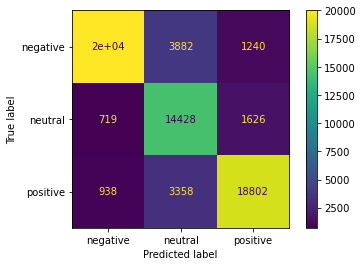

In [143]:
#Visualize Confusion Matrix for NB training set:

NB_train_cmtx=metrics.confusion_matrix(NB_train,sm_train_y)

cmtx_obj = ConfusionMatrixDisplay(NB_train_cmtx, display_labels=['negative', 'neutral', 'positive'])

cmtx_obj.plot()

#  SVM second algorithm ( NB this takes 10' to run so i have pickled)

In [190]:
#SVM is usually used for binary classification problems. 
#We will need to extend the classifier to multiclass classification (negative,neutral,positive)

#use linear SVM because it scales better with larger data and is much faster than kernel SVM
#keep same random state as before with SMOTE for consistency in results


# The linearSVC method is not followed because it follows a liblinear calculation which is not applicable for multiclass
#classification. To solve this we use svm.SVC and set the kernel to linear (by far it trains faster and gives best results)


SVM=svm.SVC(C = 0.1, kernel = 'linear' , gamma = 'auto', class_weight = 'balanced')

# SVM for train
SVM_train=SVM.fit(sm_xtrain_tfidf,sm_train_y) #pickle this

#Check prediction for SMOTED test dataset 1 because it was the largest out of the test datasets (3531 tweets)

SVM_predict_test_1=SVM.predict(test_1_for_smote)

scores=classification_report(test_labels_1,SVM_predict_test_1,output_dict=True) #use output_dict=True for readability of report

#Get macro avg f1 for test_1 data
scores




{'0': {'precision': 0.6185897435897436,
  'recall': 0.3464991023339318,
  'f1-score': 0.44418872266973536,
  'support': 557},
 '1': {'precision': 0.585635359116022,
  'recall': 0.7752659574468085,
  'f1-score': 0.6672389127324749,
  'support': 1504},
 '2': {'precision': 0.7076547231270358,
  'recall': 0.591156462585034,
  'f1-score': 0.6441808747220162,
  'support': 1470},
 'accuracy': 0.6309827244406684,
 'macro avg': {'precision': 0.6372932752776005,
  'recall': 0.5709738407885915,
  'f1-score': 0.5852028367080755,
  'support': 3531},
 'weighted avg': {'precision': 0.6416319768583197,
  'recall': 0.6309827244406684,
  'f1-score': 0.6224543554568249,
  'support': 3531}}

In [396]:
#pickle the model (serialize it into file) so ppl wont have to wait
import pickle 

with open('SVM_pickle','wb') as f:
    pickle.dump(SVM_train,f)
    
with open('SVM_pickle','rb') as f:
    pickled_svm_fit=pickle.load(f)

In [189]:
#ADD readme instruction of how to use PICKLE
SVM_predict_test_1=pickled_svm.predict(test_1_for_smote)



In [188]:
#Get macro avg f1 for test_1 data

scores['macro avg']['f1-score']

0.5852028367080755

In [185]:
# Get macro avg f1 for test_2 data

SVM_predict_test_2=SVM.predict(test_2_for_smote)

scores_2=classification_report(test_labels_2,SVM_predict_test_2,output_dict=True) #use output_dict=True for readability of report

# this shows the test statistics for class 0,1,2 ()
scores_2['macro avg']['f1-score']



0.5753397619145549

In [179]:
# Get macro avg f1 for test_3 data


SVM_predict_test_3=SVM.predict(test_3_for_smote)

scores_3=classification_report(test_labels_3,SVM_predict_test_3,output_dict=True) #use output_dict=True for readability of report

# this shows the test statistics for class 0,1,2 ()
scores_3['macro avg']['f1-score']

0.5556869122592462

In [184]:
print('Weighted f1 score of 3 classes in test_data_1',scores['macro avg']['f1-score'])
print('Weighted f1 score of 3 classes in test_data_1',scores_2['macro avg']['f1-score'])
print('Weighted f1 score of 3 classes in test_data_1',scores_3['macro avg']['f1-score'])


Weighted f1 score of 3 classes in test_data_1 0.5852028367080755
Weighted f1 score of 3 classes in test_data_1 0.5753397619145549
Weighted f1 score of 3 classes in test_data_1 0.5556869122592462


In [155]:
#Training set confusion matrix:


SVM=svm.SVC(C = 0.1, kernel = 'linear' , gamma = 'auto', class_weight = 'balanced').fit(sm_xtrain_tfidf,sm_train_y)


SVM_train_vizwiz=SVM.predict(sm_xtrain_tfidf)



In [158]:
#f1_train_SVM= f1_score(SVM_train_vizwiz,sm_xtrain_tfidf,average='weighted')

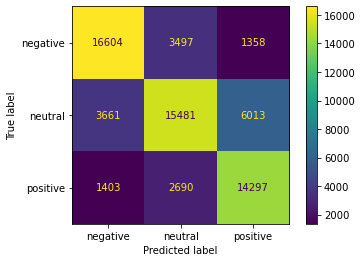

In [159]:
#visualize confusion matrix for training set SVM

SVM_train_cmtx=metrics.confusion_matrix(SVM_train_vizwiz,sm_train_y)

cmtx_obj_SVM = ConfusionMatrixDisplay(SVM_train_cmtx, display_labels=['negative', 'neutral', 'positive'])

cmtx_obj_SVM.plot()







In [161]:
#accuracy score:
print("Accuracy Score of SVM on training data:",metrics.accuracy_score(SVM_train_vizwiz,sm_train_y))

Accuracy Score of SVM on training data: 0.7135253215186758


In [ ]:
print("Accuracy Score of SVM on test data:",metrics.accuracy_score(SVM_train_vizwiz,sm_train_y))

#  LSTM using pytorch

In [389]:
#download relevant libraries

import numpy as np

import torch
#version of pytorch
print("My Pytorch version: " + torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchtext import data 
import torchtext
from torchtext.legacy import data
from torchtext.legacy.data import Field, LabelField,TabularDataset, BucketIterator
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib.cm as cm

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

My Pytorch version: 1.10.0


In [256]:
#download torch and torchtext and spacy


# Data sets 

In [366]:
#give the columns of training and test dataset only : convert them to CSV!
#this works better for the implementation

#this is appended training+dev datasets

train_final_LSTM=pd.DataFrame(df_final[['tokenized','polarity']])#47026

test_1_LSTM=pd.DataFrame(df_test_1[['tokenized','polarity']])#3531 rows




train_final_LSTM.to_csv('train_final_LSTM.csv',index=False)

test_1_LSTM.to_csv('test_1_LSTM.csv',index=False)




#  Text fields :

In [360]:
#Define label and tweet formatters one token will be one word


#this is to deal with preprocessing steps
text_field= torchtext.legacy.data.Field()# how text is tokenized

#this is to deal with out of dictionary words unk_token
label_field= torchtext.legacy.data.LabelField(dtype=torch.long)





In [386]:
# Initialize fields
Fields=[('tweets',text_field),('labels',label_field)]

In [388]:
train_LSTM,test_LSTM=TabularDataset.splits(path='',train='train_final_LSTM.csv',test='test_1_LSTM.csv',format='csv',skip_header=True, fields=Fields)








In [391]:
#LSTM architecture Layers:

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)#matrix max_voc*dim
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function Relu to avoid vanishing gradient! sigmoid wont do
        self.relu = nn.ReLU()
        
    def forward(self, text):
        
        embedded = self.dropout(self.embedding(text))
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        output=self.act(dense_outputs)
        
        return output




# General Instructions

In [393]:
#Set hyper parameters of the NN


RANDOM_SEED = 123 #set so everytime we  get the same result
torch.manual_seed(RANDOM_SEED)

vocab_size = 5000 #Vocabulary size stated in project requirements
output_dim=3 #3 classifiers
hidden_dim =312
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use 
embedding_dim = 100 # GloVe 6d embedding dimensionality stated in project requirements
dropout=0.5

In [395]:
#version for README

from platform import python_version

print(python_version())

3.8.8
